In [1]:
# F1 Timing Data Analysis and Regression

import pandas as pd
from sklearn.metrics import r2_score
import sqlite3
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import numpy as np


In [2]:

class DataLoader:
    def __init__(self, db_path):
        self.db_path = db_path

    def load_data(self):
        con = sqlite3.connect(self.db_path)
        tables = ["drivers", "fcyphases", "laps", "qualifyings", "races", "retirements", "starterfields"]
        self.dataframes = {table: pd.read_sql_query(f"SELECT * FROM {table}", con) for table in tables}
        con.close()
        return self.dataframes

class F1Model:
    def __init__(self, season, driver_id, race_id, dataframes):
        self.driver_id = driver_id
        self.season=season
        self.race_id = race_id
        self.dfs = dataframes

    def clean_data(self):

        race_ids_season=list(self.dfs["races"][self.dfs["races"]["season"]==self.season]["id"])
        laps = self.dfs['laps']
        laps = laps[(laps["driver_id"] == self.driver_id)&(laps["race_id"].isin(race_ids_season))]
        starterfields = self.dfs['starterfields']
        starterfields = starterfields[(starterfields["driver_id"] == self.driver_id)&(starterfields["race_id"].isin(race_ids_season))]
        finished_races = starterfields[starterfields['status'] == 'F']
        laps = laps[laps['race_id'].isin(finished_races['race_id'])]

        # Exclude races for Brazil and Hungary due to rain as indicated in the document
        rainy_races = ["Budapest", "SaoPaulo"]
        races = self.dfs['races']
        rainy_race_ids = races[races['location'].isin(rainy_races)]["id"]
        laps = laps[~laps['race_id'].isin(rainy_race_ids)]

      # Exclude laps under safety car or virtual safety car
        fcyphases = self.dfs['fcyphases']
        fcyphases=fcyphases[fcyphases["race_id"].isin(race_ids_season)]
        for idx,row in fcyphases.iterrows():
            begin=row["startlap"]
            end=row["endlap"]
            laps = laps[~((laps['race_id']==row["race_id"]) & (laps["lapno"].between(begin,end)))]
        

        # Exclude laps with pit stops
        laps = laps.reset_index(drop=True)
        pit_in_index = list(laps[~laps['pitintime'].isna()].index)
        pit_out_index = [lap + 1 for lap in pit_in_index]
        laps = laps[~laps.index.isin(pit_in_index+pit_out_index)]
        self.dfs['laps'] = laps
        '''display(laps[laps['race_id']==57].iloc[14])
        display(laps[laps['race_id']==57].iloc[15])'''

        


    def get_best_qualif_time(self):
        qualif_laps = self.dfs["qualifyings"]
        qualif_laps = qualif_laps[(qualif_laps["driver_id"] == self.driver_id)&(qualif_laps["race_id"].isin(self.dfs["laps"]["race_id"].unique()))]
        self.best_qualif_times = pd.DataFrame((
            qualif_laps[["race_id", "q1laptime", "q2laptime", "q3laptime"]]
            .groupby("race_id")
            .min()
            .min(axis=1)),columns=["best_qualif_time"]
        )
        self.dfs["laps"]=self.dfs["laps"].merge(self.best_qualif_times, on="race_id", how="left")


    def add_features(self):
        laps = self.dfs['laps']
        laps['fuelc'] = (
            100 - (100 / laps.groupby('race_id')['lapno'].transform('max')) * laps['lapno']
        )
        self.dfs['laps'] = laps

    def clean_to_regression(self):
        features = ['laptime','best_qualif_time', 'fuelc', 'compound', 'tireage']
        
        self.dfs["laps"]["corrected_lap_time"]=self.dfs["laps"]["laptime"]-self.dfs["laps"]["best_qualif_time"]
        self.dfs["laps"].dropna(subset = features, inplace=True)

    def split_train_test(self):
        laps = self.dfs['laps']
        start_race_id = np.min(laps['race_id'])
        self.train_data = laps[laps['race_id'].between(start_race_id, self.race_id-1)]
        self.test_data = laps[laps['race_id']==self.race_id]

    def regression_analysis(self):
        formula = "corrected_lap_time  ~  + fuelc + C(compound) + C(compound):tireage "
        # formula = "laptime ~ best_qualif_time + fuelc"
        self.model = smf.ols(formula=formula, data=self.train_data).fit()
        self.predictions = self.model.predict(self.test_data)
        plt.figure(figsize=(10, 6))
        plt.plot(self.test_data['lapno'], self.test_data['best_qualif_time']+self.test_data['corrected_lap_time'], label='Actual Lap Time', marker='o')
        plt.plot(self.test_data['lapno'], self.test_data['best_qualif_time']+self.predictions, label='Predicted Lap Time', marker='x')
        plt.xlabel('Lap Number')
        plt.ylabel('Lap Time (s)')
        plt.title(f'Predicted vs Actual Lap Times for Race ID {self.race_id}')
        plt.legend()
        plt.grid()
        plt.show()

        residuals = self.model.resid
        residual_variance = np.var(residuals, ddof=1)
        residual_sigma = np.sqrt(residual_variance)

        np.random.seed(2)
        predictions_with_volatility = self.predictions + np.random.normal(0, residual_sigma, len(self.predictions))


        # Ré avec éé la volatilité
        plt.figure(figsize=(10, 6))
        plt.plot(self.test_data['lapno'], self.test_data['best_qualif_time']+self.test_data['corrected_lap_time'], label='Actual Lap Time', marker='o')
        plt.plot(self.test_data['lapno'], self.test_data['best_qualif_time']+predictions_with_volatility, label='Predicted Lap Time', marker='x')
        plt.xlabel('Lap Number')
        plt.ylabel('Lap Time (s)')
        plt.title(f'Predicted vs Actual Lap Times with volatility for Race ID {self.race_id}')
        plt.legend()
        plt.grid()
        plt.show()

        # Calcul de R2 sans volatilité
        r2_without_volatility = r2_score(
            self.test_data['best_qualif_time'] + self.test_data['corrected_lap_time'], 
            self.test_data['best_qualif_time'] + self.predictions
        )
        print(f"R2 sur l'échantillon de test (sans volatilité) : {r2_without_volatility}")

        # Calcul de R2 avec volatilité
        r2_with_volatility = r2_score(
            self.test_data['best_qualif_time'] + self.test_data['corrected_lap_time'], 
            self.test_data['best_qualif_time'] + predictions_with_volatility
        )
        print(f"R2 sur l'échantillon de test (avec volatilité) : {r2_with_volatility}")
        return self.model.summary()

    def analyze_regression_assumptions(self, model):
        # Residual Analysis
        residuals = model.resid
        fitted = model.fittedvalues

        # Linearity and Homoscedasticity
        plt.scatter(fitted, residuals, alpha=0.5)
        plt.axhline(y=0, color='red', linestyle='--')
        plt.xlabel('Fitted Values')
        plt.ylabel('Residuals')
        plt.title('Residuals vs Fitted Values')
        plt.show()

        # Normality of Residuals
        plt.hist(residuals, bins=30, alpha=0.7)
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
        plt.title('Distribution of Residuals')
        plt.show()

        # Q-Q Plot for Normality
        import statsmodels.api as sm
        sm.qqplot(residuals, line='s')
        plt.title('Q-Q Plot of Residuals')
        plt.show()

        # Durbin-Watson Test for Autocorrelation
        dw_stat = sms.durbin_watson(residuals)
        print(f"Durbin-Watson statistic: {dw_stat}")

        # Variance Inflation Factor (VIF) for Multicollinearity
        from statsmodels.stats.outliers_influence import variance_inflation_factor
        exog = model.model.exog
        vifs = [variance_inflation_factor(exog, i) for i in range(exog.shape[1])]
        print("Variance Inflation Factors:")
        for idx, vif in enumerate(vifs):
            print(f"Variable {model.model.exog_names[idx]}: VIF = {vif:.2f}")

        # Estimate residual variance (sigma^2)
        residual_variance = np.var(residuals, ddof=1)
        print(f"Variance des résidus (sigma^2): {residual_variance}")

   

# Load data
path = "F1_timingdata_2014_2019.sqlite"
data_loader = DataLoader(path)
dataframes = data_loader.load_data()

# Initialize model
model = F1Model(driver_id=3, season=2016,race_id=46, dataframes=dataframes)
model.clean_data()
model.get_best_qualif_time()
model.add_features()
model.clean_to_regression()
model.split_train_test()
model.regression_analysis()


NameError: name 'sqlite3' is not defined

140.0

In [3]:
dataframes

NameError: name 'dataframes' is not defined

['A3' 'A2' 'A1' 'A4' 'I' 'W' 'A5' 'A6' 'A7']


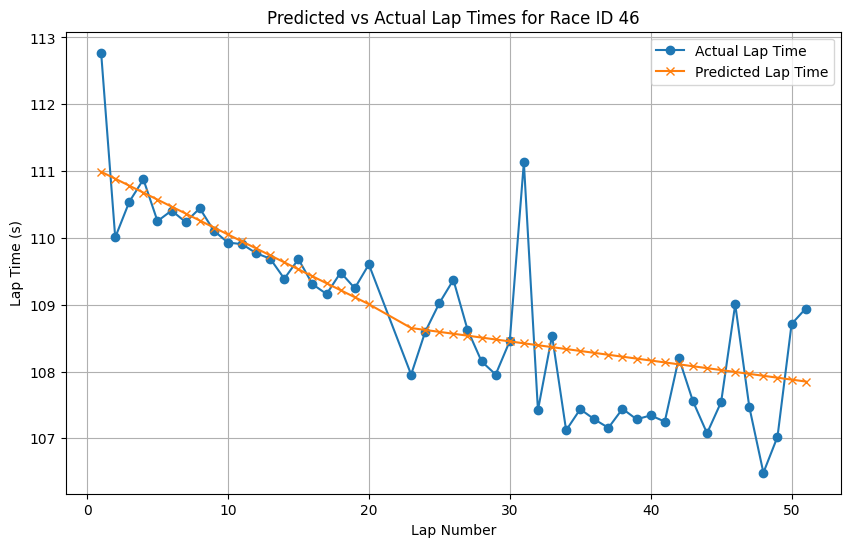

R² on the test set (without volatility): 0.6620


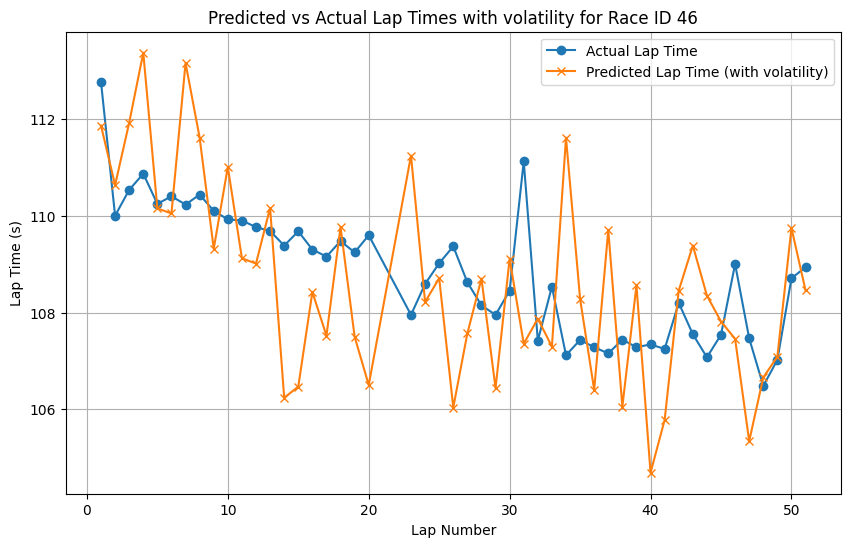

R² on the test set (with volatility): -0.7776
Variance of residuals (sigma^2): 3.1474
Residual standard deviation (sigma): 1.7741
1      6.645983
2     -0.531377
3      0.280263
4     -0.224097
5     -0.688458
         ...   
321   -1.000833
322   -1.358159
323   -1.655486
324    5.849187
325    3.398860
Length: 320, dtype: float64
                            OLS Regression Results                            
Dep. Variable:     corrected_lap_time   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     106.5
Date:                Sun, 26 Jan 2025   Prob (F-statistic):          1.03e-101
Time:                        17:06:28   Log-Likelihood:                -637.01
No. Observations:                 320   AIC:                             1300.
Df Residuals:                     307   BIC:                             1349.
Df Model:                         

In [8]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score
import statsmodels.stats.api as sms


class DataLoader:
    """
    Class responsible for loading data from an SQLite database.

    Attributes:
        db_path (str): Path to the SQLite database.
        dataframes (dict): Dictionary containing the loaded DataFrames.
    """

    def __init__(self, db_path: str):
        """
        Initialize the DataLoader class with a database path.

        Args:
            db_path (str): Path to the SQLite database.
        """
        self.db_path = db_path
        self.dataframes = {}

    def load_data(self) -> dict:
        """
        Load data from the SQLite database and store it in a dictionary.

        Returns:
            dict: A dictionary whose keys are table names and values are the corresponding DataFrames.
        """
        connection = sqlite3.connect(self.db_path)
        tables = [
            "drivers",
            "fcyphases",
            "laps",
            "qualifyings",
            "races",
            "retirements",
            "starterfields",
        ]
        self.dataframes = {
            table: pd.read_sql_query(f"SELECT * FROM {table}", connection)
            for table in tables
        }
        connection.close()
        return self.dataframes


class F1Model:
    """
    Class for data preparation and regression analysis for a given driver
    for a specific season and race.

    Attributes:
        season (int): Season to analyze.
        driver_id (int): ID of the driver.
        race_id (int): ID of the target race for testing.
        dfs (dict): Dictionary of DataFrames.
        best_qualif_times (pd.DataFrame): DataFrame with best qualifying times per race.
        train_data (pd.DataFrame): Training dataset.
        test_data (pd.DataFrame): Test dataset.
        model: Trained regression model.
        predictions (pd.Series): Predictions generated by the model on the test data.
    """

    def __init__(self, season: int, driver_id: int, race_id: int, dataframes: dict):
        """
        Initialize the F1Model class.

        Args:
            season (int): Season to analyze.
            driver_id (int): ID of the driver to analyze.
            race_id (int): ID of the race used for testing.
            dataframes (dict): Dictionary of DataFrames containing the data.
        """
        self.season = season
        self.driver_id = driver_id
        self.race_id = race_id
        self.dfs = dataframes

        self.best_qualif_times = pd.DataFrame()
        self.train_data = pd.DataFrame()
        self.test_data = pd.DataFrame()
        self.model = None
        self.predictions = pd.Series(dtype=float)

    def clean_data(self):
        """
        Cleans the data by removing:
         - Races not finished by the driver.
         - Rainy races (Hungary and Brazil).
         - Laps under safety car or virtual safety car.
         - Laps during or right after a pit stop.
        """
        # Filter season races
        race_ids_season = self.dfs["races"][self.dfs["races"]["season"] == self.season]["id"]
        laps_df = self.dfs["laps"]
        laps_df = laps_df[
            (laps_df["driver_id"] == self.driver_id)
            & (laps_df["race_id"].isin(race_ids_season))
        ]

        starterfields_df = self.dfs["starterfields"]
        starterfields_df = starterfields_df[
            (starterfields_df["driver_id"] == self.driver_id)
            & (starterfields_df["race_id"].isin(race_ids_season))
        ]

        # Keep only finished races (status = 'F')
        finished_races = starterfields_df[starterfields_df["status"] == "F"]
        laps_df = laps_df[laps_df["race_id"].isin(finished_races["race_id"])]

        # Exclude rainy races (e.g., Budapest, SaoPaulo)
        rainy_races = ["Budapest", "SaoPaulo"]
        races_df = self.dfs["races"]
        rainy_race_ids = races_df[races_df["location"].isin(rainy_races)]["id"]
        laps_df = laps_df[~laps_df["race_id"].isin(rainy_race_ids)]

        # Exclude laps under Safety Car (fcyphases)
        fcyphases_df = self.dfs["fcyphases"]
        fcyphases_df = fcyphases_df[fcyphases_df["race_id"].isin(race_ids_season)]
        for _, row in fcyphases_df.iterrows():
            begin = row["startlap"]
            end = row["endlap"]
            laps_df = laps_df[
                ~(
                    (laps_df["race_id"] == row["race_id"])
                    & (laps_df["lapno"].between(begin, end))
                )
            ]

        # Exclude laps with pit stops and the following lap
        laps_df = laps_df.reset_index(drop=True)
        pit_in_index = laps_df[~laps_df["pitintime"].isna()].index
        pit_out_index = [i + 1 for i in pit_in_index]
        laps_df = laps_df[~laps_df.index.isin(list(pit_in_index) + pit_out_index)]

        # Update the laps DataFrame in self.dfs
        self.dfs["laps"] = laps_df

    def get_best_qualif_time(self):
        """
        Retrieves the best qualification time (Q1, Q2, or Q3) for each race
        and adds it as a 'best_qualif_time' column in the 'laps' DataFrame.
        """
        qualif_laps_df = self.dfs["qualifyings"]
        valid_race_ids = self.dfs["laps"]["race_id"].unique()
        qualif_laps_df = qualif_laps_df[
            (qualif_laps_df["driver_id"] == self.driver_id)
            & (qualif_laps_df["race_id"].isin(valid_race_ids))
        ]

        # Compute the best qualifying time
        best_qualif_times = (
            qualif_laps_df[["race_id", "q1laptime", "q2laptime", "q3laptime"]]
            .groupby("race_id")
            .min()
            .min(axis=1)
        )
        self.best_qualif_times = pd.DataFrame(
            best_qualif_times, columns=["best_qualif_time"]
        )

        # Merge with the laps DataFrame
        self.dfs["laps"] = self.dfs["laps"].merge(
            self.best_qualif_times, on="race_id", how="left"
        )

    def add_features(self):
        """
        Adds explanatory variables to the 'laps' DataFrame, including the estimated
        amount of remaining fuel ('fuelc').
        """
        laps_df = self.dfs["laps"].copy()

        # Simple estimation of remaining fuel based on the total number of laps
        laps_df["fuelc"] = (
            100
            - (100 / laps_df.groupby("race_id")["lapno"].transform("max"))
            * laps_df["lapno"]
        )

        self.dfs["laps"] = laps_df

    def clean_to_regression(self):
        """
        Prepares the data for regression by:
         - Creating the 'corrected_lap_time' column = laptime - best_qualif_time.
         - Dropping rows with missing values in the relevant variables.
        """
        required_features = ["laptime", "best_qualif_time", "fuelc", "compound", "tireage"]

        self.dfs["laps"]["corrected_lap_time"] = (
            self.dfs["laps"]["laptime"] - self.dfs["laps"]["best_qualif_time"]
        )

        self.dfs["laps"].dropna(subset=required_features, inplace=True)

    def split_train_test(self):
        """
        Splits the 'laps' DataFrame into two subsets:
         - A training set (train_data) for races between the first race of the season
           and race_id - 1 (inclusive).
         - A test set (test_data) for the race_id race.
        """
        laps_df = self.dfs["laps"]
        start_race_id = np.min(laps_df["race_id"])

        # Training: races in [start_race_id, race_id-1]
        self.train_data = laps_df[laps_df["race_id"].between(start_race_id, self.race_id - 1)]
        # Test: race = race_id
        self.test_data = laps_df[laps_df["race_id"] == self.race_id]

    def regression_analysis(self):
        """
        Performs a regression analysis on the training set and compares the predictions
        with the test set. Returns a summary of the model.

        Returns:
            statsmodels.iolib.summary.Summary: Statistical summary of the model.
        """
        # Define the regression formula
        formula = "corrected_lap_time ~ fuelc + C(compound) + C(compound):tireage"

        # Fit the model
        self.model = smf.ols(formula=formula, data=self.train_data).fit()

        # Predict on the test set
        self.predictions = self.model.predict(self.test_data)

        # Visualization: Predictions vs. actual values
        plt.figure(figsize=(10, 6))
        plt.plot(
            self.test_data["lapno"],
            self.test_data["best_qualif_time"] + self.test_data["corrected_lap_time"],
            label="Actual Lap Time",
            marker="o",
        )
        plt.plot(
            self.test_data["lapno"],
            self.test_data["best_qualif_time"] + self.predictions,
            label="Predicted Lap Time",
            marker="x",
        )
        plt.xlabel("Lap Number")
        plt.ylabel("Lap Time (s)")
        plt.title(f"Predicted vs Actual Lap Times for Race ID {self.race_id}")
        plt.legend()
        plt.grid()
        plt.show()

        # Calculate R² without volatility
        r2_without_volatility = r2_score(
            self.test_data["best_qualif_time"] + self.test_data["corrected_lap_time"],
            self.test_data["best_qualif_time"] + self.predictions,
        )
        print(f"R² on the test set (without volatility): {r2_without_volatility:.4f}")

        # Compute residual variance and standard deviation
        residuals = self.model.resid
        residual_variance = np.var(residuals, ddof=1)
        residual_sigma = np.sqrt(residual_variance)

        # Add random volatility to predictions
        np.random.seed(42)
        predictions_with_volatility = self.predictions + np.random.normal(
            0, residual_sigma, len(self.predictions)
        )

        # Visualization with volatility
        plt.figure(figsize=(10, 6))
        plt.plot(
            self.test_data["lapno"],
            self.test_data["best_qualif_time"] + self.test_data["corrected_lap_time"],
            label="Actual Lap Time",
            marker="o",
        )
        plt.plot(
            self.test_data["lapno"],
            self.test_data["best_qualif_time"] + predictions_with_volatility,
            label="Predicted Lap Time (with volatility)",
            marker="x",
        )
        plt.xlabel("Lap Number")
        plt.ylabel("Lap Time (s)")
        plt.title(
            f"Predicted vs Actual Lap Times with volatility for Race ID {self.race_id}"
        )
        plt.legend()
        plt.grid()
        plt.show()

        # Calculate R² with volatility
        r2_with_volatility = r2_score(
            self.test_data["best_qualif_time"] + self.test_data["corrected_lap_time"],
            self.test_data["best_qualif_time"] + predictions_with_volatility,
        )
        print(f"R² on the test set (with volatility): {r2_with_volatility:.4f}")


        print(f"Variance of residuals (sigma^2): {residual_variance:.4f}")
        print(f"Residual standard deviation (sigma): {residual_sigma:.4f}")
        return self.model.summary()

    def analyze_regression_assumptions(self, model):
        """
        Analyzes the regression assumptions (linearity, normality, homoscedasticity, 
        autocorrelation, multicollinearity).
        
        Args:
            model (statsmodels.regression.linear_model.RegressionResultsWrapper):
                The OLS-fitted regression model.
        """
        residuals = model.resid
        fitted = model.fittedvalues

        # Linearity and Homoscedasticity
        plt.scatter(fitted, residuals, alpha=0.5)
        plt.axhline(y=0, color="red", linestyle="--")
        plt.xlabel("Fitted Values")
        plt.ylabel("Residuals")
        plt.title("Residuals vs. Fitted Values")
        plt.show()

        # Normality of Residuals
        plt.hist(residuals, bins=30, alpha=0.7)
        plt.xlabel("Residuals")
        plt.ylabel("Frequency")
        plt.title("Distribution of Residuals")
        plt.show()

        # Q-Q Plot for Normality
        import statsmodels.api as sm
        sm.qqplot(residuals, line="s")
        plt.title("Q-Q Plot of Residuals")
        plt.show()

        # Durbin-Watson test for autocorrelation
        dw_stat = sms.durbin_watson(residuals)
        print(f"Durbin-Watson statistic: {dw_stat:.4f}")

        # Variance Inflation Factor (VIF) for multicollinearity
        from statsmodels.stats.outliers_influence import variance_inflation_factor
        exog = model.model.exog
        vifs = [variance_inflation_factor(exog, i) for i in range(exog.shape[1])]
        print("Variance Inflation Factors (VIF):")
        for idx, vif in enumerate(vifs):
            print(f"Variable {model.model.exog_names[idx]}: VIF = {vif:.2f}")

        # Estimate of residual variance
        residual_variance = np.var(residuals, ddof=1)
        print(f"Variance of residuals (sigma^2): {residual_variance:.4f}")

    '''def get_parameters(self):
        #recuperer les coefficients de la regression et la volatilité
        parameters = self.model.params
        volatility = self.model.resid
        pass'''

def regression(self):
    formula = "corrected_lap_time ~ fuelc + C(compound) + C(compound):tireage"
    self.model = smf.ols(formula=formula, data=self.train_data).fit()


def get_model_and_variability(self):
    # Return a dictionnary with the regression coefficients
    self.clean_data()
    self.get_best_qualif_time()
    self.add_features()
    self.clean_to_regression()
    self.split_train_test()
    self.regression()
    self.variability =np.std((self.model.resid))
    return(self.model, self.variability)




def main():
    
    # Load data
    db_path = "F1_timingdata_2014_2019.sqlite"
    data_loader = DataLoader(db_path=db_path)
    dataframes = data_loader.load_data()

    print(dataframes["laps"]["compound"].unique())
    # Initialize the model
    model = F1Model(season=2016, driver_id=3, race_id=46, dataframes=dataframes)
    
    model.clean_data()
    model.get_best_qualif_time()
    model.add_features()
    model.clean_to_regression()
    model.split_train_test()

    # Run the regression analysis
    summary = model.regression_analysis()
    print(model.model.resid)
    print(summary)
    print(model.model.params.to_dict())

    


if __name__ == "__main__":
    main()


In [2]:
db_path = "F1_timingdata_2014_2019.sqlite"
data_loader = DataLoader(db_path=db_path)
dataframes2 = data_loader.load_data()
laps2=dataframes2["laps"]

In [3]:
race_ids_season=list(model.dfs["races"][model.dfs["races"]["season"]==model.season]["id"])
laps2 = laps2[(laps2["race_id"].isin(race_ids_season))]
starterfields2 = dataframes2['starterfields']
starterfields2 = starterfields2[(starterfields2["race_id"].isin(race_ids_season))]
laps_2_merged = pd.merge(
    laps2, 
    starterfields2, 
    on=["driver_id", "race_id"],  # Jointure multiple
    how="inner"  # inner, left, etc., selon votre besoin
)

# 1) Sélectionner seulement les colonnes utiles
pits_data = laps_2_merged[laps_2_merged["pitstopduration"].notna()][
    ["race_id", "driver_id", "team", "pitstopduration"]
]

# 2) Supprimer les doublons sur (driver_id, race_id, pitstopduration)
#    afin de ne garder qu'une ligne par pit stop unique
pits_data = pits_data.drop_duplicates(subset=["race_id", "driver_id", "pitstopduration"])

# 3) Calculer la moyenne de la durée de pit stop par écurie
avg_pitstop_by_team = (
    pits_data[pits_data["pitstopduration"]<700]
    .groupby("team")["pitstopduration"]
    .mean()
    .reset_index()
    .rename(columns={"pitstopduration": "mean_pitstop_duration"})
)

# 4) Afficher le résultat
print(avg_pitstop_by_team)

plt.hist(pits_data[(pits_data["team"]=="Mercedes")&(pits_data["pitstopduration"]<700)]["pitstopduration"])

NameError: name 'model' is not defined

## Correlation steps

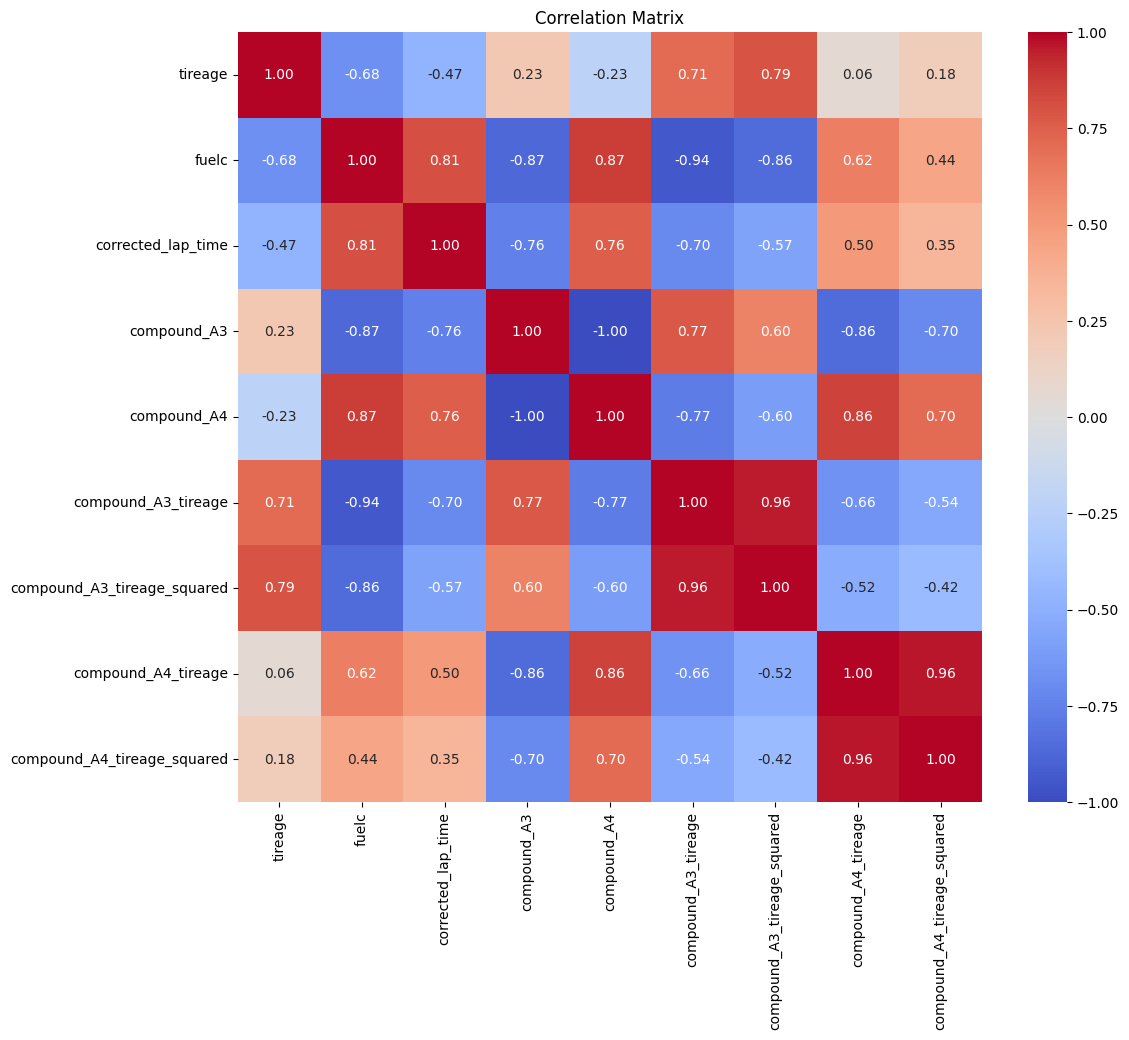

In [ ]:
df=model.test_data[['compound', 'tireage',      'fuelc', 'corrected_lap_time']]

dummies = pd.get_dummies(df['compound'], prefix='compound')

df = pd.concat([df, dummies], axis=1)

for dummy_col in dummies.columns:
    df[f'{dummy_col}_tireage'] = df[dummy_col] * df['tireage']
    df[f'{dummy_col}_tireage_squared'] = df[dummy_col] * (df['tireage'])** 2
df.drop(columns=["compound"],inplace=True)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [ ]:
correlation_matrix=df.corr()

# Sélectionner les corrélations avec `corrected_lap_time`
correlations_with_target = correlation_matrix['corrected_lap_time'].drop('corrected_lap_time')
correlations_with_target = correlations_with_target.abs().sort_values(ascending=False)

# Garder les variables les plus corrélées à `corrected_lap_time`
selected_variables = []
removed_variables = set()

for var in correlations_with_target.index:
    if var not in removed_variables:
        selected_variables.append(var)
        # Vérifier la corrélation entre la variable sélectionnée et les autres
        high_corr_vars = correlation_matrix[var][
            correlation_matrix[var].abs() > 0.8
        ].index
        removed_variables.update(high_corr_vars)

# Afficher les variables sélectionnées
print("Variables sélectionnées :")
print(selected_variables)

# Créer un nouveau DataFrame avec seulement les variables sélectionnées
filtered_df = df[selected_variables + ['corrected_lap_time']]


Variables sélectionnées :
['fuelc', 'compound_A4_tireage', 'tireage']

Variables supprimées :
{'compound_A3_tireage', 'compound_A4', 'compound_A4_tireage_squared', 'compound_A3_tireage_squared', 'compound_A3'}
